In [3]:
import pandas as pd
import gensim
import numpy as np
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

# no_added_sugar

## Data Preprocessing

In [4]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'no_added_sugar')

In [5]:
df['meal_ingredients'].isnull().sum()

0

In [6]:
df = df.dropna(axis=0, subset=['meal_ingredients'])

In [7]:
df['meal_ingredients'].isnull().sum()

0

In [8]:
df['meal_ingredients'] = df['meal_ingredients'].astype(str)

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def preprocess_meals(meal):
    processed_meal = meal
    processed_meal.replace('[^\w\s]', '')
    processed_meal = " ".join(word for word in processed_meal.split() if word not in stop_words)
    #processed_meal = " ".join(word for word in processed_meal.split() if word not in custom_stopwords)
    processed_meal = " ".join(Word(word).lemmatize() for word in processed_meal.split())
    return(processed_meal)

In [11]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
df['expert_assessment'] = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [12]:
total = df['expert_assessment'].count()
negative = df['expert_assessment'][df['expert_assessment']==0].count()
positive = df['expert_assessment'][df['expert_assessment']==1].count()
print('Total observations:', total)
print('Total negative labels:', negative)
print('Total positive labels:', positive)

Total observations: 433
Total negative labels: 82
Total positive labels: 351


# TFIDF


## Meal Ingredients

In [13]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [14]:
df['meal_ingredients']

0      Liverwurst/Gouda cheese sandwich lettuce tomat...
1                                                   Test
2      3 x medium pancake syrup, 1 x tangerine 1 x 12...
3      Spice ham cheese sandwich, mayo butter. 1 x 12...
4                                           Beef pot pie
                             ...                        
428                                  Butter roll coffee.
429                     White rice,Roman bean pork chop.
430               Is ground meat lettuce tomato cucumber
431    Arrow com Gandules Dos Pasteles de platano car...
432                          Eggs Sausage Quinoa Peppers
Name: meal_ingredients, Length: 433, dtype: object

In [15]:
document = []
for i in df['meal_ingredients']:
    if i != '':
        document.append(i)

In [16]:
document

['Liverwurst/Gouda cheese sandwich lettuce tomato mustard on12 grain bread. 12 oz cup black coffee 1 x tspn raw sugar.',
 'Test',
 '3 x medium pancake syrup, 1 x tangerine 1 x 12 oz cup black coffee 2 x tspn raw sugar.',
 'Spice ham cheese sandwich, mayo butter. 1 x 12oz cup black coffee 2 x tspn raw sugar.',
 'Beef pot pie',
 'Filled beef vegetable pot pie',
 'Spinach quish 12 oz cup black coffee 2 x tspn sugar',
 'Fried chicken French fry salad',
 'Half Ciabatta bread butter, lightly smeared. 1 x hard-boiled egg 1 x banana. 1 x 15 oz bottle orange juice.',
 'Ms. Dash & Garlic Powder',
 'Roast Beef Hero pepper jack cheese, lettuce/tomato mayo lightly smeared. And 1 x 33 oz bottle water.',
 'Chocolate almond',
 'Half cup oatmeal banana',
 'Special omelet, eggs, onions, pepper chorizo. 12oz cup black coffee 2 x tspn raw sugar.',
 'Pain Bagnat sandwich tuna, hard-boiled egg. Lettuce, tomato, onion, olives, oil balsamic vinegar. 1 x banana 1 x 12oz cup black coffee 2 x tspn sugar.',
 'Whi

In [17]:
data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [19]:
print(X_train.shape, X_test.shape)

(346,) (87,)


In [20]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=40, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


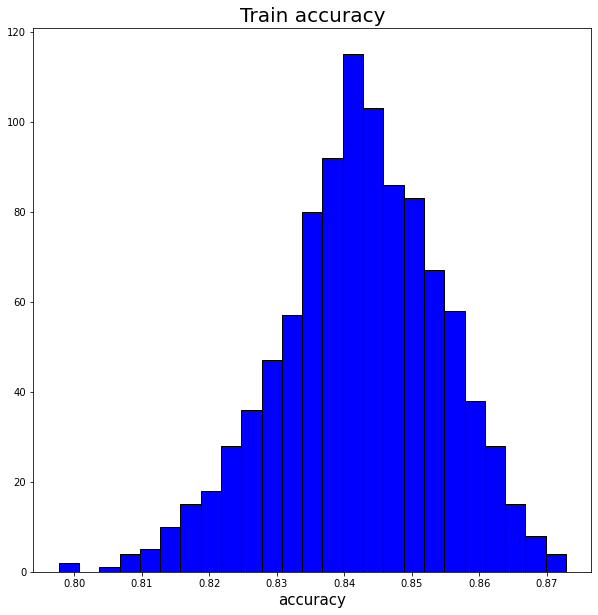

In [21]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [22]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8419335260115606
0.011623930731269896


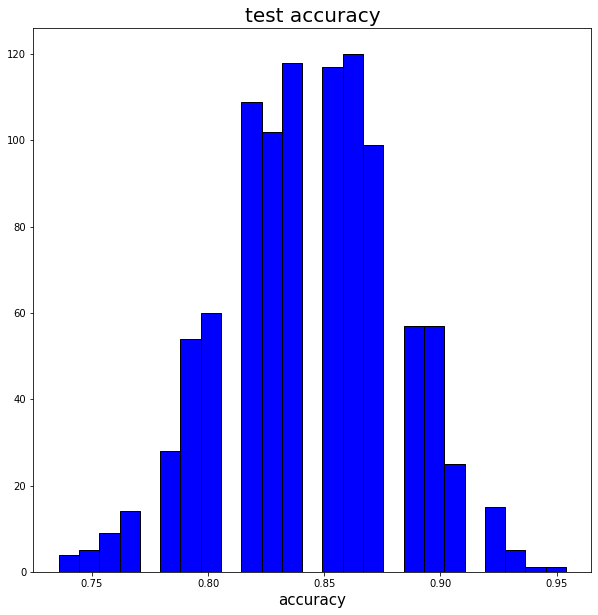

In [23]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [24]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8437011494252873
0.03640321888729152


# TFIDF Meal Title

In [25]:
df['meal_title'].isnull().sum()

0

In [26]:
df['meal_title'] = df['meal_title'].astype(str)

In [27]:
df = df.dropna(axis=0, subset=['meal_title'])

In [28]:
df['meal_title'].isnull().sum()

0

In [29]:
document = []
for i in df['meal_title']:
    if i != '':
        document.append(i)

In [30]:
data_X = np.squeeze(pd.DataFrame(df['meal_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [32]:
print(X_train.shape, X_test.shape)

(346,) (87,)


In [33]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

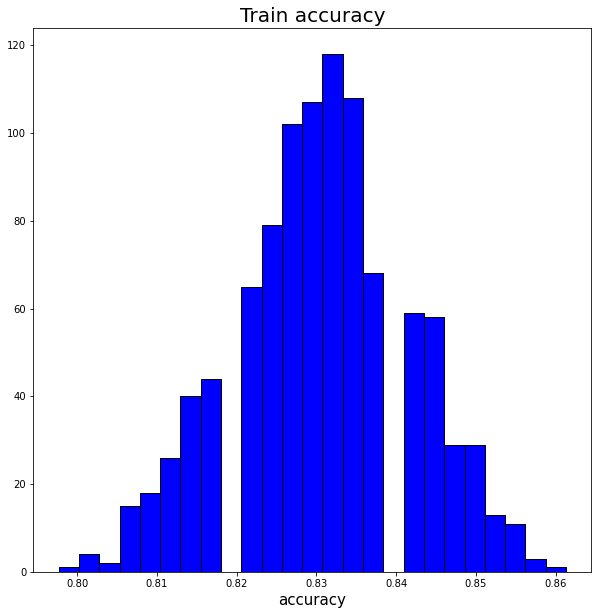

In [34]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [35]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8305867052023121
0.010885757100055933


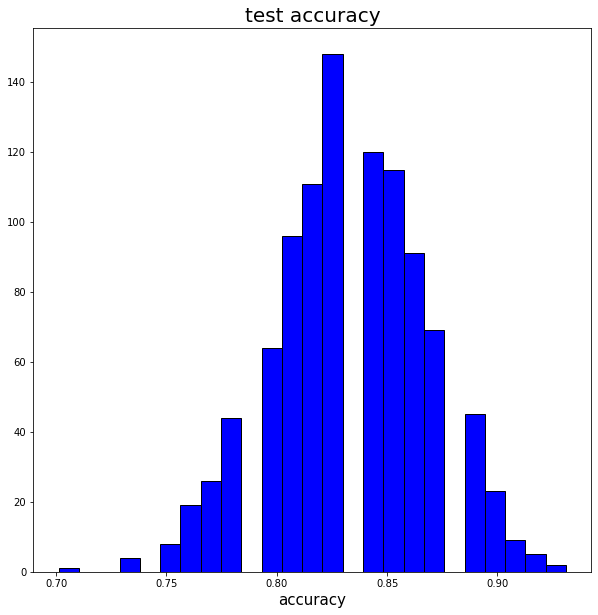

In [36]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [37]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8318275862068966
0.03471347909476562


# TFIDF Ingredients + Title

In [38]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [39]:
document = []
for i in df['ingredients_and_title']:
    if i != '':
        document.append(i)

In [40]:
document

['Liverwurst/Gouda cheese sandwich lettuce tomato mustard on12 grain bread. 12 oz cup black coffee 1 x tspn raw sugar. Liverwurst/Gouda cheese sandwich w/lettuce, tomato and mustard on 12 grain bread.',
 'Test Test',
 '3 x medium pancake syrup, 1 x tangerine 1 x 12 oz cup black coffee 2 x tspn raw sugar. 3 x medium pancake with syrup and tangerine. 1 x 12 oz cup of black coffee with 2 x sugars.',
 'Spice ham cheese sandwich, mayo butter. 1 x 12oz cup black coffee 2 x tspn raw sugar. Spice ham and cheese sandwich. Cup of black coffee.',
 'Beef pot pie Pot pie',
 'Filled beef vegetable pot pie Pot pie',
 'Spinach quish 12 oz cup black coffee 2 x tspn sugar Spinach quish and 12 oz cup of black coffee',
 'Fried chicken French fry salad Dinnersalad.',
 'Half Ciabatta bread butter, lightly smeared. 1 x hard-boiled egg 1 x banana. 1 x 15 oz bottle orange juice. Raisin Ciabatta bread with butter, lightly smeared. 1 x hard-boiled egg and 1 x banana. 1 x 15 oz bottle of orange juice.',
 'Ms. Das

In [41]:
data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [43]:
print(X_train.shape, X_test.shape)

(346,) (87,)


In [44]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


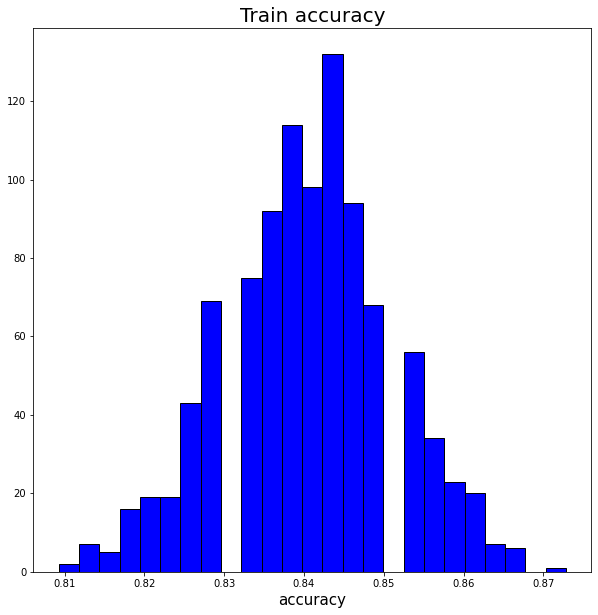

In [45]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [46]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8404364161849711
0.010423601431596053


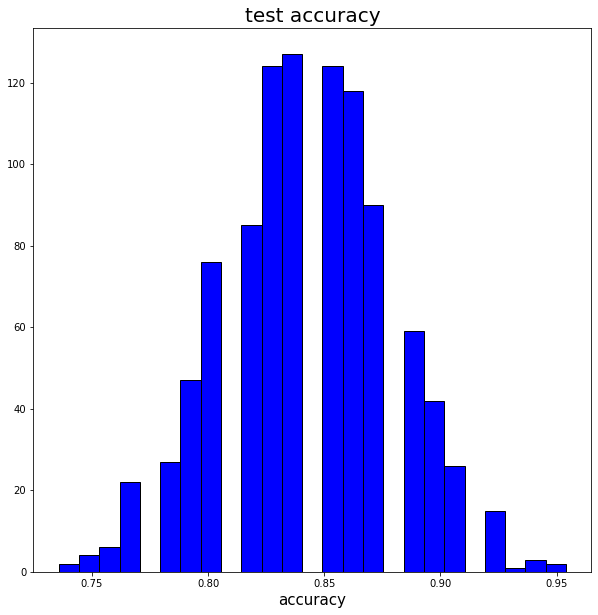

In [47]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [48]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8427931034482758
0.03552574201736719


# Word2vec

## ingredients

In [49]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [50]:
meal_ingredients = df.meal_ingredients.apply(gensim.utils.simple_preprocess)

In [51]:
meal_ingredients

0      [liverwurst, gouda, cheese, sandwich, lettuce,...
1                                                 [test]
2      [medium, pancake, syrup, tangerine, oz, cup, b...
3      [spice, ham, cheese, sandwich, mayo, butter, o...
4                                       [beef, pot, pie]
                             ...                        
428                               [butter, roll, coffee]
429               [white, rice, roman, bean, pork, chop]
430        [is, ground, meat, lettuce, tomato, cucumber]
431    [arrow, com, gandules, dos, pasteles, de, plat...
432                     [eggs, sausage, quinoa, peppers]
Name: meal_ingredients, Length: 433, dtype: object

In [52]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients, progress_per = 100)

embeddings.train(meal_ingredients, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients = embeddings.wv.index_to_key

In [53]:
learned_words_meal_ingredients

['cup',
 'oz',
 'water',
 'cheese',
 'egg',
 'chicken',
 'bottle',
 'garlic',
 'white',
 'black',
 'dash',
 'rice',
 'pepper',
 'tomato',
 'powder',
 'coffee',
 'tbsp',
 'mrs',
 'salad',
 'lettuce',
 'sweeter',
 'red',
 'sugar',
 'cheddar',
 'onion',
 'bread',
 'parsley',
 'butter',
 'tbsps',
 'cinnamon',
 'boiled',
 'tsp',
 'mayonnaise',
 'pam',
 'bacon',
 'hard',
 'bean',
 'spray',
 'fried',
 'fry',
 'banana',
 'salmon',
 'greek',
 'sauce',
 'beef',
 'sausage',
 'protein',
 'packs',
 'veg',
 'cals',
 'cream',
 'sandwich',
 'green',
 'carbs',
 'almond',
 'eggs',
 'pork',
 'stir',
 'breast',
 'tspn',
 'half',
 'beans',
 'onions',
 'dressing',
 'yogurt',
 'romaine',
 'broccoli',
 'fat',
 'none',
 'slice',
 'oatmeal',
 'large',
 'pear',
 'pack',
 'raw',
 'mixed',
 'corn',
 'smoked',
 'carrots',
 'steak',
 'ms',
 'wheat',
 'avocado',
 'danjou',
 'oil',
 'peppers',
 'ratatouille',
 'soup',
 'yellow',
 'celery',
 'mustard',
 'soy',
 'sugars',
 'added',
 'olive',
 'cucumber',
 'bar',
 'feta'

In [54]:
words = []
for i in meal_ingredients:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [55]:
l = []
eg = 0
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [56]:
data_y = np.squeeze(data_y)
data_y.shape

(433,)

In [57]:
data_X = pd.DataFrame(l)
data_X.shape

(433, 100)

In [58]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

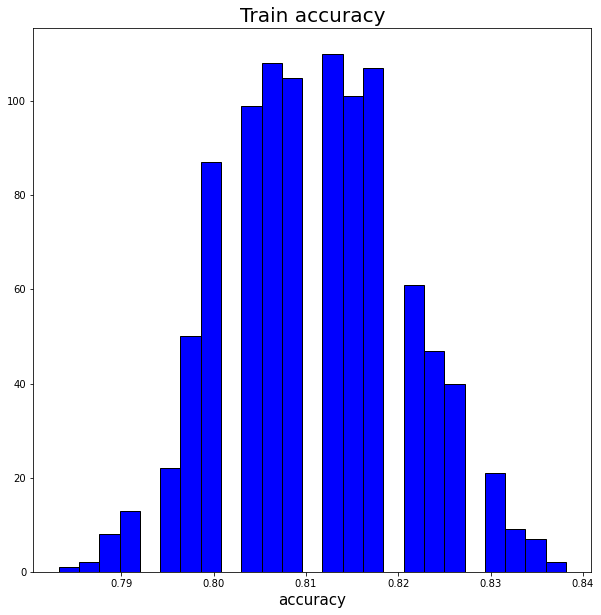

In [59]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [60]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.811034682080925
0.009482269161299172


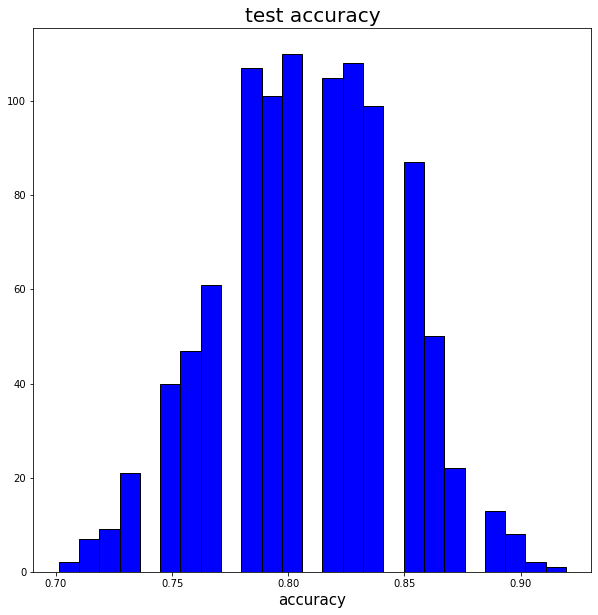

In [61]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [62]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8089885057471263
0.03771109344608636


## title

In [63]:
df['meal_title'].isnull().sum()

0

In [64]:
df['meal_title'] = df['meal_title'].astype(str)

In [65]:
df = df.dropna(axis=0, subset=['meal_title'])

In [66]:
df['meal_title'].isnull().sum()

0

In [67]:
meal_title = df.meal_title.apply(gensim.utils.simple_preprocess)

In [68]:
meal_title

0      [liverwurst, gouda, cheese, sandwich, lettuce,...
1                                                 [test]
2      [medium, pancake, with, syrup, and, tangerine,...
3      [spice, ham, and, cheese, sandwich, cup, of, b...
4                                             [pot, pie]
                             ...                        
428                                             [coffee]
429                                       [rice, dinner]
430                                              [salad]
431    [yellow, rice, with, handles, and, two, pastel...
432                   [kellogg, äôs, special, frittatas]
Name: meal_title, Length: 433, dtype: object

In [69]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_title, progress_per = 100)

embeddings.train(meal_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_title = embeddings.wv.index_to_key

In [70]:
learned_words_meal_title

['and',
 'oz',
 'of',
 'chicken',
 'water',
 'salad',
 'rice',
 'egg',
 'cheese',
 'bottle',
 'with',
 'eggs',
 'beans',
 'coffee',
 'bran',
 'oat',
 'sausage',
 'brown',
 'pork',
 'white',
 'omelette',
 'cup',
 'turkey',
 'salmon',
 'banana',
 'mixed',
 'sandwich',
 'black',
 'bread',
 'boiled',
 'veg',
 'hard',
 'oatmeal',
 'steak',
 'yogurt',
 'greek',
 'string',
 'butter',
 'cream',
 'broccoli',
 'pear',
 'ratatouille',
 'yams',
 'fry',
 'stir',
 'tomato',
 'bar',
 'lettuce',
 'beef',
 'apple',
 'red',
 'breast',
 'half',
 'cheddar',
 'protein',
 'tomatoes',
 'yellow',
 'almond',
 'fries',
 'carb',
 'meal',
 'fried',
 'ground',
 'carrots',
 'onions',
 'spinach',
 'test',
 'äôs',
 'ham',
 'on',
 'rite',
 'vegetables',
 'salsa',
 'veggie',
 'chop',
 'no',
 'potato',
 'soup',
 'roast',
 'guacamole',
 'bites',
 'meatballs',
 'starbucks',
 'wheat',
 'french',
 'roll',
 'cooked',
 'coconut',
 'fish',
 'blueberries',
 'stawberries',
 'peppers',
 'bacon',
 'large',
 'peanut',
 'cantaloupe'

In [71]:
words = []
for i in meal_title:
    temp = []
    for j in i:
        if j in learned_words_meal_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [72]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [73]:
data_y = np.squeeze(data_y)
data_y.shape

(433,)

In [74]:
data_X = pd.DataFrame(l)
data_X.shape

(433, 100)

In [75]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

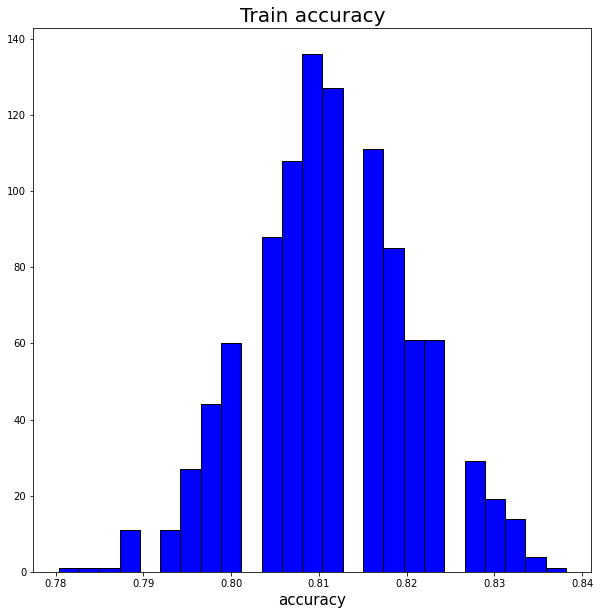

In [76]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [77]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8111936416184972
0.009247683755936464


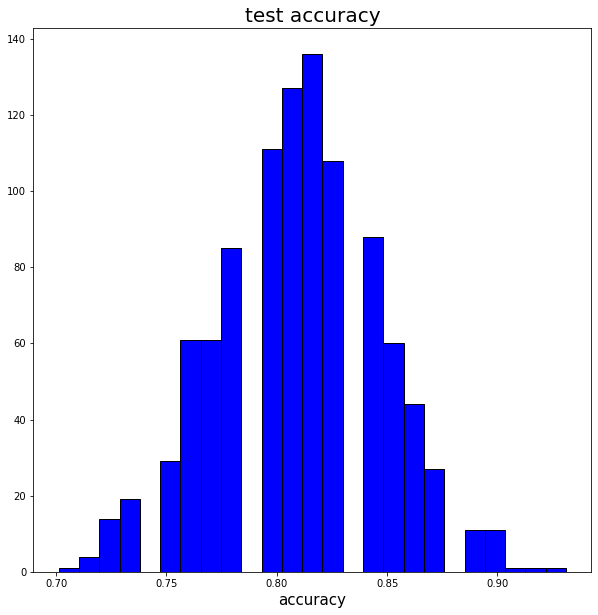

In [78]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [79]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8083563218390805
0.03677814459257492


## ingredients_and_title

In [80]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [81]:
df['ingredients_and_title']

0      Liverwurst/Gouda cheese sandwich lettuce tomat...
1                                              Test Test
2      3 x medium pancake syrup, 1 x tangerine 1 x 12...
3      Spice ham cheese sandwich, mayo butter. 1 x 12...
4                                   Beef pot pie Pot pie
                             ...                        
428                           Butter roll coffee. Coffee
429         White rice,Roman bean pork chop. Rice dinner
430         Is ground meat lettuce tomato cucumber Salad
431    Arrow com Gandules Dos Pasteles de platano car...
432    Eggs Sausage Quinoa Peppers Kellogg‚Äôs specia...
Name: ingredients_and_title, Length: 433, dtype: object

In [82]:
meal_ingredients_title = df.ingredients_and_title.apply(gensim.utils.simple_preprocess)

In [83]:
meal_ingredients_title

0      [liverwurst, gouda, cheese, sandwich, lettuce,...
1                                           [test, test]
2      [medium, pancake, syrup, tangerine, oz, cup, b...
3      [spice, ham, cheese, sandwich, mayo, butter, o...
4                             [beef, pot, pie, pot, pie]
                             ...                        
428                       [butter, roll, coffee, coffee]
429    [white, rice, roman, bean, pork, chop, rice, d...
430    [is, ground, meat, lettuce, tomato, cucumber, ...
431    [arrow, com, gandules, dos, pasteles, de, plat...
432    [eggs, sausage, quinoa, peppers, kellogg, äôs,...
Name: ingredients_and_title, Length: 433, dtype: object

In [84]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients_title, progress_per = 100)

embeddings.train(meal_ingredients_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients_title = embeddings.wv.index_to_key

In [85]:
learned_words_meal_ingredients_title

['oz',
 'and',
 'cup',
 'water',
 'chicken',
 'egg',
 'cheese',
 'rice',
 'bottle',
 'salad',
 'of',
 'coffee',
 'white',
 'black',
 'eggs',
 'beans',
 'garlic',
 'tomato',
 'with',
 'pepper',
 'sausage',
 'dash',
 'bread',
 'lettuce',
 'powder',
 'boiled',
 'red',
 'banana',
 'pork',
 'salmon',
 'butter',
 'cheddar',
 'tbsp',
 'hard',
 'sugar',
 'mrs',
 'sandwich',
 'veg',
 'greek',
 'bran',
 'brown',
 'onion',
 'fry',
 'sweeter',
 'mixed',
 'oat',
 'cream',
 'beef',
 'turkey',
 'oatmeal',
 'yogurt',
 'fried',
 'bacon',
 'tsp',
 'stir',
 'broccoli',
 'tbsps',
 'steak',
 'protein',
 'pear',
 'parsley',
 'cinnamon',
 'mayonnaise',
 'breast',
 'almond',
 'half',
 'bean',
 'pam',
 'omelette',
 'onions',
 'ratatouille',
 'sauce',
 'spray',
 'carrots',
 'bar',
 'packs',
 'large',
 'string',
 'green',
 'yellow',
 'carbs',
 'cals',
 'soup',
 'dressing',
 'wheat',
 'spinach',
 'tspn',
 'celery',
 'potato',
 'avocado',
 'ham',
 'peppers',
 'slice',
 'test',
 'jam',
 'tomatoes',
 'smoked',
 'pac

In [86]:
words = []
for i in meal_ingredients_title:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [87]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [88]:
data_y = np.squeeze(data_y)
data_y.shape

(433,)

In [89]:
data_X = pd.DataFrame(l)
data_X.shape

(433, 100)

In [90]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

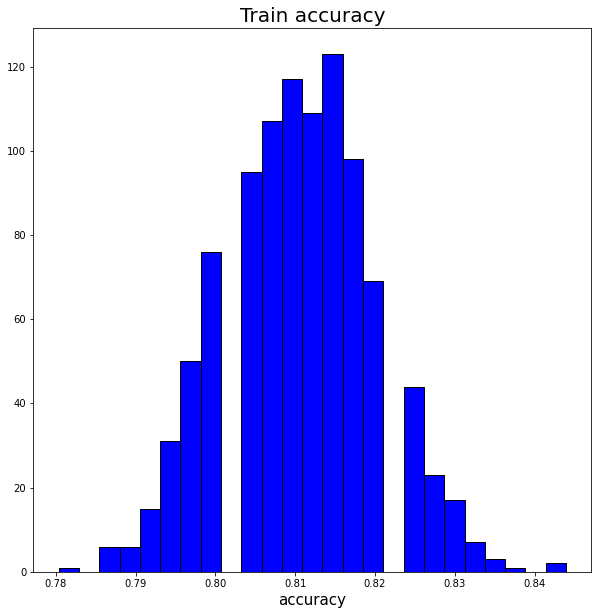

In [91]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [92]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8105462427745665
0.009270836148203253


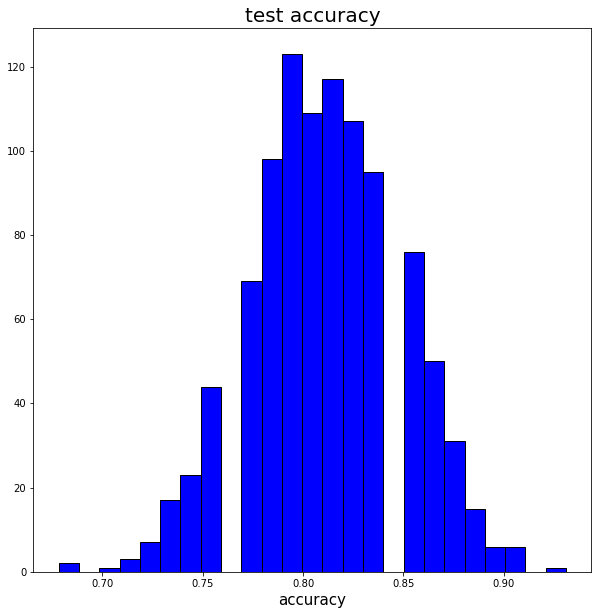

In [93]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [94]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8109310344827586
0.03687022192273938


# no_added_sugar

### meal ingredients

In [2]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'no_added_sugar')

In [3]:
df['meal_ingredients'].isnull().sum()

0

In [4]:
df = df.dropna(axis=0, subset=['meal_ingredients'])

In [5]:
# df = df.dropna(axis=0, subset=['expert_assessment'])

In [6]:
df['meal_ingredients'].isnull().sum()

0

In [7]:
df['meal_ingredients'] = df['meal_ingredients'].astype(str)

In [8]:
meal_ingredients = df.meal_ingredients.apply(gensim.utils.simple_preprocess)

In [9]:
meal_ingredients

0      [liverwurst, gouda, cheese, sandwich, with, le...
1                                                 [test]
2      [medium, pancake, with, syrup, tangerine, and,...
3      [spice, ham, and, cheese, sandwich, no, mayo, ...
4                                       [beef, pot, pie]
                             ...                        
428                               [butter, roll, coffee]
429              [white, rice, roman, beans, pork, chop]
430    [is, ground, meat, with, lettuce, and, tomato,...
431    [arrow, com, gandules, dos, pasteles, de, plat...
432                     [eggs, sausage, quinoa, peppers]
Name: meal_ingredients, Length: 433, dtype: object

In [10]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients, progress_per = 100)

embeddings.train(meal_ingredients, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients = embeddings.wv.index_to_key

In [11]:
learned_words_meal_ingredients

['and',
 'oz',
 'of',
 'cup',
 'water',
 'with',
 'cheese',
 'chicken',
 'cups',
 'bottle',
 'garlic',
 'black',
 'egg',
 'dash',
 'rice',
 'powder',
 'coffee',
 'tbsp',
 'eggs',
 'pepper',
 'mrs',
 'salad',
 'lettuce',
 'red',
 'sweeter',
 'beans',
 'cheddar',
 'sugar',
 'tomato',
 'white',
 'bread',
 'parsley',
 'tbsps',
 'butter',
 'cinnamon',
 'boiled',
 'tsp',
 'packs',
 'pam',
 'mayonnaise',
 'onions',
 'bacon',
 'whites',
 'spray',
 'hard',
 'tomatoes',
 'fried',
 'onion',
 'banana',
 'greek',
 'salmon',
 'sauce',
 'beef',
 'protein',
 'peppers',
 'veg',
 'carbs',
 'cream',
 'sandwich',
 'sausage',
 'cals',
 'green',
 'pork',
 'fry',
 'half',
 'stir',
 'carrots',
 'tspn',
 'broccoli',
 'yogurt',
 'romaine',
 'dressing',
 'fat',
 'pear',
 'mixed',
 'none',
 'raw',
 'large',
 'slices',
 'breast',
 'no',
 'oatmeal',
 'sugars',
 'smoked',
 'steak',
 'corn',
 'on',
 'danjou',
 'wheat',
 'oil',
 'ms',
 'avocado',
 'soup',
 'mustard',
 'soy',
 'celery',
 'almonds',
 'yellow',
 'ratatou

In [12]:
words = []
for i in meal_ingredients:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [13]:
l = []
eg = 0
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [14]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
data_y = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [15]:
data_y = np.squeeze(data_y)
data_y.shape

(433,)

In [16]:
data_X = pd.DataFrame(l)
data_X.shape

(433, 100)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
model = lr.fit(X_train, y_train)

In [19]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score
print('train accurcy:',accuracy_score(y_train, y_pred_train))
print('test accurcy:',accuracy_score(y_test, y_pred_test))

train accurcy: 0.8034682080924855
test accurcy: 0.8390804597701149


In [21]:
# #Kfold

# for i in range(2,10,1):
#     k = i

#     kf = KFold(n_splits=k, random_state=None)
#     model = LogisticRegression()

#     train_acc_score = []
#     test_acc_score = []

#     for train_index , test_index in kf.split(data_X):
#         X_train , X_test = data_X.iloc[train_index,:],data_X.iloc[test_index,:]
#         y_train , y_test = data_y[train_index] , data_y[test_index]

#         model.fit(X_train,y_train)

#         y_pred_train = model.predict(X_train)
#         y_pred_test = model.predict(X_test)

#         test_acc = accuracy_score(y_test, y_pred_test)
#         test_acc_score.append(test_acc)
#         train_acc = accuracy_score(y_train, y_pred_train)
#         train_acc_score.append(train_acc)


#     train_avg_acc_score = sum(train_acc_score)/k
#     test_avg_acc_score = sum(test_acc_score)/k
#     print('train accuracy for k:' + str(k) + ' is ' +  str(train_avg_acc_score))
#     print('test accuracy for k:' + str(k) + ' is ' +  str(test_avg_acc_score))
#     print()

### meal title

In [22]:
df['meal_title'].isnull().sum()

0

In [23]:
df['meal_title'] = df['meal_title'].astype(str)

In [24]:
df = df.dropna(axis=0, subset=['meal_title'])

In [25]:
df['meal_title'].isnull().sum()

0

In [26]:
meal_title = df.meal_title.apply(gensim.utils.simple_preprocess)

In [27]:
meal_title

0      [liverwurst, gouda, cheese, sandwich, lettuce,...
1                                                 [test]
2      [medium, pancake, with, syrup, and, tangerine,...
3      [spice, ham, and, cheese, sandwich, cup, of, b...
4                                             [pot, pie]
                             ...                        
428                                             [coffee]
429                                       [rice, dinner]
430                                              [salad]
431    [yellow, rice, with, handles, and, two, pastel...
432                   [kellogg, äôs, special, frittatas]
Name: meal_title, Length: 433, dtype: object

In [28]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_title, progress_per = 100)

embeddings.train(meal_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_title = embeddings.wv.index_to_key

In [29]:
learned_words_meal_title

['and',
 'oz',
 'of',
 'chicken',
 'water',
 'salad',
 'rice',
 'egg',
 'cheese',
 'bottle',
 'with',
 'eggs',
 'beans',
 'coffee',
 'bran',
 'oat',
 'sausage',
 'brown',
 'pork',
 'white',
 'omelette',
 'cup',
 'turkey',
 'salmon',
 'banana',
 'mixed',
 'sandwich',
 'black',
 'bread',
 'boiled',
 'veg',
 'hard',
 'oatmeal',
 'steak',
 'yogurt',
 'greek',
 'string',
 'butter',
 'cream',
 'broccoli',
 'pear',
 'ratatouille',
 'yams',
 'fry',
 'stir',
 'tomato',
 'bar',
 'lettuce',
 'beef',
 'apple',
 'red',
 'breast',
 'half',
 'cheddar',
 'protein',
 'tomatoes',
 'yellow',
 'almond',
 'fries',
 'carb',
 'meal',
 'fried',
 'ground',
 'carrots',
 'onions',
 'spinach',
 'test',
 'äôs',
 'ham',
 'on',
 'rite',
 'vegetables',
 'salsa',
 'veggie',
 'chop',
 'no',
 'potato',
 'soup',
 'roast',
 'guacamole',
 'bites',
 'meatballs',
 'starbucks',
 'wheat',
 'french',
 'roll',
 'cooked',
 'coconut',
 'fish',
 'blueberries',
 'stawberries',
 'peppers',
 'bacon',
 'large',
 'peanut',
 'cantaloupe'

In [30]:
words = []
for i in meal_title:
    temp = []
    for j in i:
        if j in learned_words_meal_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [31]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [32]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
data_y = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [33]:
data_y = np.squeeze(data_y)
data_y.shape

(433,)

In [34]:
data_X = pd.DataFrame(l)
data_X.shape

(433, 100)

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [36]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
model = lr.fit(X_train, y_train)

In [37]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [38]:
from sklearn.metrics import accuracy_score
print('train accurcy:',accuracy_score(y_train, y_pred_train))
print('test accurcy:',accuracy_score(y_test, y_pred_test))

train accurcy: 0.8236994219653179
test accurcy: 0.7586206896551724


In [39]:
# #Kfold

# for i in range(2,10,1):
#     k = i

#     kf = KFold(n_splits=k, random_state=None)
#     model = LogisticRegression()

#     train_acc_score = []
#     test_acc_score = []

#     for train_index , test_index in kf.split(data_X):
#         X_train , X_test = data_X.iloc[train_index,:],data_X.iloc[test_index,:]
#         y_train , y_test = data_y[train_index] , data_y[test_index]

#         model.fit(X_train,y_train)

#         y_pred_train = model.predict(X_train)
#         y_pred_test = model.predict(X_test)

#         test_acc = accuracy_score(y_test, y_pred_test)
#         test_acc_score.append(test_acc)
#         train_acc = accuracy_score(y_train, y_pred_train)
#         train_acc_score.append(train_acc)


#     train_avg_acc_score = sum(train_acc_score)/k
#     test_avg_acc_score = sum(test_acc_score)/k
#     print('train accuracy for k:' + str(k) + ' is ' +  str(train_avg_acc_score))
#     print('test accuracy for k:' + str(k) + ' is ' +  str(test_avg_acc_score))
#     print()

### ingredients_and_title

In [40]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [41]:
df['ingredients_and_title']

0      Liverwurst/Gouda cheese sandwich with lettuce ...
1                                              Test Test
2      3 x medium pancake with syrup, 1 x tangerine a...
3      Spice ham and cheese sandwich, no mayo or butt...
4                                   Beef pot pie Pot pie
                             ...                        
428                           Butter roll coffee. Coffee
429        White rice,Roman beans pork chop. Rice dinner
430    Is ground meat with lettuce  and tomato and cu...
431    Arrow com Gandules y Dos Pasteles de platano y...
432    Eggs\nSausage\nQuinoa\nPeppers Kellogg‚Äôs spe...
Name: ingredients_and_title, Length: 433, dtype: object

In [42]:
meal_ingredients_title = df.ingredients_and_title.apply(gensim.utils.simple_preprocess)

In [43]:
meal_ingredients_title

0      [liverwurst, gouda, cheese, sandwich, with, le...
1                                           [test, test]
2      [medium, pancake, with, syrup, tangerine, and,...
3      [spice, ham, and, cheese, sandwich, no, mayo, ...
4                             [beef, pot, pie, pot, pie]
                             ...                        
428                       [butter, roll, coffee, coffee]
429    [white, rice, roman, beans, pork, chop, rice, ...
430    [is, ground, meat, with, lettuce, and, tomato,...
431    [arrow, com, gandules, dos, pasteles, de, plat...
432    [eggs, sausage, quinoa, peppers, kellogg, äôs,...
Name: ingredients_and_title, Length: 433, dtype: object

In [44]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients_title, progress_per = 100)

embeddings.train(meal_ingredients_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients_title = embeddings.wv.index_to_key

In [45]:
learned_words_meal_ingredients_title

['and',
 'oz',
 'of',
 'water',
 'cup',
 'chicken',
 'with',
 'cheese',
 'rice',
 'bottle',
 'egg',
 'salad',
 'eggs',
 'coffee',
 'beans',
 'black',
 'cups',
 'garlic',
 'white',
 'dash',
 'sausage',
 'lettuce',
 'bread',
 'powder',
 'boiled',
 'red',
 'banana',
 'salmon',
 'pork',
 'tomato',
 'butter',
 'cheddar',
 'pepper',
 'hard',
 'tbsp',
 'mrs',
 'sandwich',
 'brown',
 'veg',
 'bran',
 'greek',
 'sweeter',
 'sugar',
 'mixed',
 'oat',
 'onions',
 'cream',
 'turkey',
 'beef',
 'yogurt',
 'fried',
 'tomatoes',
 'oatmeal',
 'bacon',
 'broccoli',
 'tsp',
 'tbsps',
 'fry',
 'stir',
 'pear',
 'protein',
 'steak',
 'mayonnaise',
 'parsley',
 'onion',
 'cinnamon',
 'whites',
 'half',
 'packs',
 'peppers',
 'omelette',
 'pam',
 'carrots',
 'sauce',
 'breast',
 'ratatouille',
 'spray',
 'no',
 'bar',
 'green',
 'string',
 'large',
 'carbs',
 'on',
 'cals',
 'yellow',
 'fries',
 'spinach',
 'wheat',
 'almond',
 'tspn',
 'dressing',
 'soup',
 'celery',
 'avocado',
 'ham',
 'smoked',
 'potato

In [46]:
words = []
for i in meal_ingredients_title:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [47]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [48]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
data_y = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [49]:
data_y = np.squeeze(data_y)
data_y.shape

(433,)

In [50]:
data_X = pd.DataFrame(l)
data_X.shape

(433, 100)

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
model = lr.fit(X_train, y_train)

In [53]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [54]:
from sklearn.metrics import accuracy_score
print('train accurcy:',accuracy_score(y_train, y_pred_train))
print('test accurcy:',accuracy_score(y_test, y_pred_test))

train accurcy: 0.8121387283236994
test accurcy: 0.8045977011494253


In [55]:
# #Kfold

# for i in range(2,10,1):
#     k = i

#     kf = KFold(n_splits=k, random_state=None)
#     model = LogisticRegression()

#     train_acc_score = []
#     test_acc_score = []

#     for train_index , test_index in kf.split(data_X):
#         X_train , X_test = data_X.iloc[train_index,:],data_X.iloc[test_index,:]
#         y_train , y_test = data_y[train_index] , data_y[test_index]

#         model.fit(X_train,y_train)

#         y_pred_train = model.predict(X_train)
#         y_pred_test = model.predict(X_test)

#         test_acc = accuracy_score(y_test, y_pred_test)
#         test_acc_score.append(test_acc)
#         train_acc = accuracy_score(y_train, y_pred_train)
#         train_acc_score.append(train_acc)


#     train_avg_acc_score = sum(train_acc_score)/k
#     test_avg_acc_score = sum(test_acc_score)/k
#     print('train accuracy for k:' + str(k) + ' is ' +  str(train_avg_acc_score))
#     print('test accuracy for k:' + str(k) + ' is ' +  str(test_avg_acc_score))
#     print()